# Word2Vec: Skipgram Model
-------------------------------------

In this example, we will download and preprocess the movie review data.

From this data set we will compute/fit the skipgram model of the Word2Vec Algorithm

Skipgram: based on predicting the surrounding words from the

Ex sentence "the cat in the hat"
 - context word:  ["hat"]
 - target words: ["the", "cat", "in", "the"]
 - context-target pairs: ("hat", "the"), ("hat", "cat"), ("hat", "in"), ("hat", "the")

We start by loading the necessary libraries.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import os
import string
import requests
import collections
import io
import tarfile
import gzip
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

Start a computational graph session.

In [2]:
sess = tf.Session()

Declare model parameters

In [3]:
batch_size = 100         # How many sets of words to train on at once.
embedding_size = 100    # The embedding size of each word to train.
vocabulary_size = 2000 # How many words we will consider for training.
generations = 100000    # How many iterations we will perform the training on.
print_loss_every = 1000  # Print the loss every so many iterations

num_sampled = int(batch_size/2) # Number of negative examples to sample.
window_size = 5         # How many words to consider left and right.

We will remove stop words and create a test validation set of words.

In [4]:
# Declare stop words
stops = stopwords.words('english')

# We pick five test words. We are expecting synonyms to appear
print_valid_every = 10000
valid_words = ['cliche', 'love', 'hate', 'silly', 'sad']
# Later we will have to transform these into indices

Next, we load the movie review data.  We check if the data was downloaded, and not, download and save it.

In [12]:
def load_movie_data():
    save_folder_name = 'temp'
    pos_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.neg')

    # Check if files are already downloaded
    if not os.path.exists(os.path.join(save_folder_name, 'rt-polaritydata')):
        movie_data_url = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'

        # Save tar.gz file
        req = requests.get(movie_data_url, stream=True)
        with open(os.path.join(save_folder_name,'temp_movie_review_temp.tar.gz'), 'wb') as f:
            for chunk in req.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    f.flush()
        # Extract tar.gz file into temp folder
        tar = tarfile.open(os.path.join(save_folder_name,'temp_movie_review_temp.tar.gz'), "r:gz")
        tar.extractall(path='temp')
        tar.close()
    
    pos_data = []
    #with open(pos_file, 'r', encoding='latin-1') as f:
    with open(pos_file, 'r') as f:
        for line in f:
            pos_data.append(line)#.encode('ascii',errors='ignore').decode())
    f.close()
    pos_data = [x.rstrip() for x in pos_data]

    neg_data = []
    #with open(neg_file, 'r', encoding='latin-1') as f:
    with open(neg_file, 'r') as f:
        for line in f:
            neg_data.append(line)#.encode('ascii',errors='ignore').decode())
    f.close()
    neg_data = [x.rstrip() for x in neg_data]
    
    #pos_data = [x.rstrip() for x in pos_data]
    #neg_data = [x.rstrip() for x in neg_data]
    
    texts = pos_data + neg_data
    target = [1]*len(pos_data) + [0]*len(neg_data)
    
    return(texts, target)


texts, target = load_movie_data()

Now we create a function that normalizes/cleans the text.

In [13]:
# Normalize text
def normalize_text(texts, stops):
    # Lower case
    texts = [x.lower() for x in texts]

    # Remove punctuation
    texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

    # Remove numbers
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

    # Remove stopwords
    texts = [' '.join([word for word in x.split() if word not in (stops)]) for x in texts]

    # Trim extra whitespace
    texts = [' '.join(x.split()) for x in texts]
    
    return(texts)
    
texts = normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]

/home/jerry/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


With the normalized movie reviews, we now build a dictionary of words.

In [14]:
# Build dictionary of words
def build_dictionary(sentences, vocabulary_size):
    # Turn sentences (list of strings) into lists of words
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    
    # Initialize list of [word, word_count] for each word, starting with unknown
    count = [['RARE', -1]]
    
    # Now add most frequent words, limited to the N-most frequent (N=vocabulary size)
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    
    # Now create the dictionary
    word_dict = {}
    # For each word, that we want in the dictionary, add it, then make it
    # the value of the prior dictionary length
    for word, word_count in count:
        word_dict[word] = len(word_dict)
    
    return(word_dict)

With the above dictionary, we can turn text data into lists of integers from such dictionary.

In [15]:
def text_to_numbers(sentences, word_dict):
    # Initialize the returned data
    data = []
    for sentence in sentences:
        sentence_data = []
        # For each word, either use selected index or rare word index
        for word in sentence.split(' '):
            if word in word_dict:
                word_ix = word_dict[word]
            else:
                word_ix = 0
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return(data)

# Build our data set and dictionaries
word_dictionary = build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]

Let us now build a function that will generate random data points from our text and parameters.

In [16]:
# Generate data randomly (N words behind, target, N words ahead)
def generate_batch_data(sentences, batch_size, window_size, method='skip_gram'):
    # Fill up data batch
    batch_data = []
    label_data = []
    while len(batch_data) < batch_size:
        # select random sentence to start
        rand_sentence = np.random.choice(sentences)
        # Generate consecutive windows to look at
        window_sequences = [rand_sentence[max((ix-window_size),0):(ix+window_size+1)] for ix, x in enumerate(rand_sentence)]
        # Denote which element of each window is the center word of interest
        label_indices = [ix if ix<window_size else window_size for ix,x in enumerate(window_sequences)]
        
        # Pull out center word of interest for each window and create a tuple for each window
        if method=='skip_gram':
            batch_and_labels = [(x[y], x[:y] + x[(y+1):]) for x,y in zip(window_sequences, label_indices)]
            # Make it in to a big list of tuples (target word, surrounding word)
            tuple_data = [(x, y_) for x,y in batch_and_labels for y_ in y]
        elif method=='cbow':
            batch_and_labels = [(x[:y] + x[(y+1):], x[y]) for x,y in zip(window_sequences, label_indices)]
            # Make it in to a big list of tuples (target word, surrounding word)
            tuple_data = [(x_, y) for x,y in batch_and_labels for x_ in x]
        else:
            raise ValueError('Method {} not implemented yet.'.format(method))
            
        # extract batch and labels
        batch, labels = [list(x) for x in zip(*tuple_data)]
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
    # Trim batch and label at the end
    batch_data = batch_data[:batch_size]
    label_data = label_data[:batch_size]
    
    # Convert to numpy array
    batch_data = np.array(batch_data)
    label_data = np.transpose(np.array([label_data]))
    
    return(batch_data, label_data)

Next we define our model and placeholders.

In [17]:
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                               stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[batch_size])
y_target = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Lookup the word embedding:
embed = tf.nn.embedding_lookup(embeddings, x_inputs)

Here is our loss function, optimizer, cosine similarity, and initialization of the model variables.

For the loss function we will minimize the average of the NCE loss (noise-contrastive estimation).

In [18]:
# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))

# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)


#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

In [19]:
sim_init = sess.run(similarity)

Now we can train our skip-gram model.

In [20]:
# Run the skip gram model.
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = generate_batch_data(text_data, batch_size, window_size)
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(optimizer, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print("Loss at step {} : {}".format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                score = sim[j,nearest[k]]
                log_str = "%s %s," % (log_str, close_word)
            print(log_str)

Loss at step 1000 : 5.42025613785
Loss at step 2000 : 4.35336399078
Loss at step 3000 : 5.06757545471
Loss at step 4000 : 4.46739673615
Loss at step 5000 : 4.09109020233
Loss at step 6000 : 4.10543203354
Loss at step 7000 : 3.84273386002
Loss at step 8000 : 4.0267829895
Loss at step 9000 : 4.36373329163
Loss at step 10000 : 3.76077127457
Nearest to cliche: elaborate, christian, uplifting, cultural, lane,
Nearest to love: car, film, little, id, make,
Nearest to hate: early, RARE, handsome, mindless, unintentionally,
Nearest to silly: believe, analyze, creativity, intended, cute,
Nearest to sad: smile, one, guys, RARE, becomes,
Loss at step 11000 : 4.03137969971
Loss at step 12000 : 5.05955934525
Loss at step 13000 : 3.8888092041
Loss at step 14000 : 4.19817733765
Loss at step 15000 : 4.48618412018
Loss at step 16000 : 4.30534410477
Loss at step 17000 : 4.56413841248
Loss at step 18000 : 4.0878071785
Loss at step 19000 : 3.59161353111
Loss at step 20000 : 3.86878490448
Nearest to cliche:

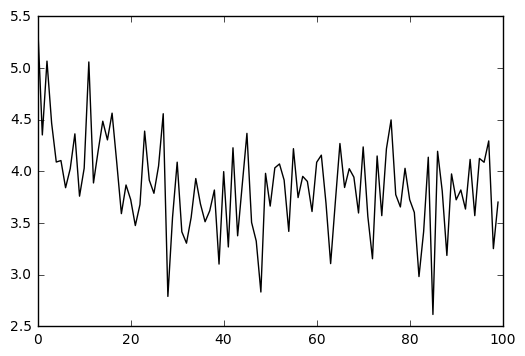

In [21]:
plt.plot(loss_vec,'k-')
plt.show()

In [24]:
len(loss_vec)

100